In [ ]:
!pip3 uninstall Pillow -y
!pip3 install Pillow
!pip uninstall Pillow -y
!pip install Pillow

In [ ]:
"""
AFTER YOU RUN THIS CELL, MAKE SURE YOU RESTART RUNTIME COLAB AND
RUN IT AGAIN FROM FIRST CELL
"""
# Download all packages
from google.colab import files, output

!rm -rf vortex plot
!git clone https://github.com/nodefluxio/vortex.git
!cd vortex && git checkout drop-enforce && pip install --ignore-installed --timeout=10000 ./src/development
!cd vortex && pip install --ignore-installed --timeout=10000 ./src/runtime[onnxruntime]
!apt-get install pciutils -y
!pip install torchtext==0.7
!pip install comet-ml
!rm -rf vortex
!mkdir plot

output.clear()
print("Pakcages installed!")

Pakcages installed!


In [ ]:
# Import all packages
import os
import comet_ml
import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from pytorch_lightning.callbacks import EarlyStopping
from vortex.development.networks.models import ModelBase
from vortex.development.exporter.onnx import ONNXExporter
from vortex.development.utils.profiler.lightning import Profiler
from vortex.development.utils.metrics import ClassificationMetrics
from vortex.development.utils.runtime_wrapper import RuntimeWrapper

print("All packages loaded!")

All packages loaded!


In [ ]:
# Upload API files from kaggle
!rm kaggle.json

files.upload()
output.clear()
print("Files uploaded!")

Files uploaded!


In [ ]:
# Connect colab to kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

output.clear()
print("Collab connected to Kaggle!")

Collab connected to Kaggle!


In [ ]:
# Download datasets
!rm split-garbage-dataset.zip
!kaggle datasets download -d andreasantoro/split-garbage-dataset

output.clear()
print("Datasets downloaded!")

Datasets downloaded!


In [ ]:
# Extract datasets
!rm -rf split-garbage-dataset test train valid
!unzip split-garbage-dataset.zip
!rm -rf test train valid

output.clear()
print("Datasets extracted!")

Datasets extracted!


In [ ]:
# Set directory datasets
root_dir = "./split-garbage-dataset"
train_dir = os.path.join(root_dir, "train")
valid_dir = os.path.join(root_dir, "valid")
test_dir = os.path.join(root_dir, "test")

print("Directory datasets has been set up!")

Directory datasets has been set up!


In [ ]:
# Create datasets
class DatasetDataModule(pl.LightningDataModule):
    def __init__(self, train_dir, valid_dir, test_dir,
                 img_size, num_workers=2, batch_size=32, 
                 mean_normalize_image=(0.485, 0.456, 0.406), 
                 std_normalize_image=(0.229, 0.224, 0.225)):
        
        super().__init__()
        self.train_dir = train_dir
        self.valid_dir = valid_dir
        self.test_dir = test_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.mean_normalize_image = mean_normalize_image
        self.std_normalize_image = std_normalize_image

        self.image_transforms = {
            "train": transforms.Compose([
                transforms.Resize(size=(self.img_size,
                                        self.img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=(0, 90)),
                transforms.RandomPerspective(),
                transforms.ToTensor(),
                transforms.Normalize(self.mean_normalize_image,
                                    self.std_normalize_image)
            ]),
            "valid": transforms.Compose([
                transforms.Resize(size=(self.img_size,
                                        self.img_size)),
                transforms.ToTensor(),
                transforms.Normalize(self.mean_normalize_image,
                                    self.std_normalize_image)
            ]),
            "test": transforms.Compose([
                transforms.Resize(size=(self.img_size,
                                        self.img_size)),
                transforms.ToTensor(),
                transforms.Normalize(self.mean_normalize_image,
                                    self.std_normalize_image)
            ]),
        }

        self.train_set = datasets.ImageFolder(root=self.train_dir, 
                                             transform=self.image_transforms["train"])
        self.valid_set = datasets.ImageFolder(root=self.valid_dir, 
                                             transform=self.image_transforms["valid"])
        self.test_set = datasets.ImageFolder(root=self.test_dir, 
                                             transform=self.image_transforms["test"])

        self.class_names = self.train_set.classes
        self.num_classes = len(self.class_names)

    def train_dataloader(self):
        train_loader = DataLoader(dataset=self.train_set, batch_size=self.batch_size, 
                                  num_workers=self.num_workers, shuffle=True
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(dataset=self.valid_set, batch_size=self.batch_size, 
                                  num_workers=self.num_workers, shuffle=False
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(dataset=self.test_set, batch_size=self.batch_size, 
                                  num_workers=self.num_workers, shuffle=False
        )
        return test_loader

print("DataModule Created!")

DataModule Created!


In [ ]:
# Create Models
class LitNeuralNet(ModelBase):
    def __init__(self, num_classes, learning_rate=0.0001):
        super().__init__()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        self.metrics = ClassificationMetrics()

        self.model = models.resnet152(pretrained=True)
        # for param in self.model.parameters():
        #     param.required_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, self.num_classes)
        # self.model.fc = nn.Sequential(
        #     nn.Linear(self.model.fc.in_features, self.256),
        #     nn.ReLU(),
        #     nn.Dropout(0.4),
        #     nn.BatchNorm1d(256),

        #     nn.Linear(256, 512),
        #     nn.ReLU(),
        #     nn.Dropout(0.4),
        #     nn.BatchNorm1d(512),

        #     nn.Linear(512, 1028),
        #     nn.ReLU(),
        #     nn.Dropout(0.4),
        #     nn.BatchNorm1d(1028),

        #     nn.Linear(1028, self.num_classes),
        # )

    def postprocess(self, x):
        x = F.softmax(x, dim=1)
        conf_label, cls_label = x.max(dim=1, keepdim=True)
        return torch.stack((cls_label.float(), conf_label), dim=1)

    def predict(self, x):
        preds = self.model(x)
        return self.postprocess(preds)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x)
        loss = self.criterion(preds, y)
        self.log('train_loss', loss, on_step=True, 
                 on_epoch=True, prog_bar=True, logger=True)
        prediction = self.postprocess(preds)
        self.metrics.update(prediction.cpu().detach(), y.cpu().detach())
        return loss

    def training_epoch_end(self, outs):
        self.log_dict(self.metrics.compute())
        self.metrics.eval_init()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        with torch.no_grad():
            preds = self.predict(x)
        preds = preds[:,:]
        result = self.metrics(preds.cpu(), y.cpu())
        self.log_dict(result)

    def validation_epoch_end(self, *args, **kwargs):
        self.log_dict(self.metrics.compute(), on_epoch=True, 
                      prog_bar=True, logger=True)
        self.metrics.eval_init()

    def validation_step_end(self, validation_step_outputs):
        self.log_dict(self.metrics.compute(), on_epoch=True, 
                      prog_bar=True, logger=True)

    def on_export_start(self, exporter, dataset=None):
        batch_size = exporter.batch_size
        self.sample = next(iter(dataset.train_dataloader()))[0]
        self.sample = self.sample[:batch_size]
        self.class_names = dataset.class_names
        self._input_names = ['input']
        self._output_names = ['output']

    def get_example_inputs(self):
        return self.sample

    @property
    def input_names(self):
        return self._input_names

    @property
    def output_names(self):
        return self._output_names

    @property
    def available_metrics(self):
        return self.metrics

    @property
    def output_format(self):
        return {
            "class_label": {"indices": [0], "axis": 0},
            "class_confidence": {"indices": [1], "axis": 0}
        }

print("Model created!")

Model created!


In [ ]:
# Create Callbacks
callbacks = [
    EarlyStopping(monitor='accuracy', patience=5, 
                  verbose=True, mode='auto')
]
print("Callbacks ready!")

EarlyStopping mode set to max for monitoring accuracy.


Callbacks ready!


In [ ]:
# Create Hyperparameters
export_path = 'saved_model.onnx'
img_size = 256
num_epochs = 50
learning_rate = 5.5e-5

print("Hyperparameter Created!")

Hyperparameter Created!


In [ ]:
# Create function to train and eval
# You can use comet-ml for log your model
def train(train_dir, valid_dir, test_dir, img_size,
          num_epochs=50, callbacks=[], learning_rate=0.0001,
          export_path="saved_model.onnx", api_key_comet_logger=None,
          project_name_comet_logger=None, workspace_comet_logger=None):
    
    if api_key_comet_logger is None or \
    project_name_comet_logger is None or \
    workspace_comet_logger is None:
        loggers = [pl.loggers.TensorBoardLogger('logs/')]
    else:
        loggers = [pl.loggers.TensorBoardLogger('logs/'),
                pl.loggers.CometLogger(api_key=api_key_comet_logger,
                                        project_name=project_name_comet_logger,
                                        workspace=workspace_comet_logger)]
    dataset = DatasetDataModule(train_dir, valid_dir, 
                                 test_dir, img_size)
    num_classes = dataset.num_classes
    trainer = pl.Trainer(max_epochs=num_epochs, gpus=-1, 
                         logger=loggers, callbacks=callbacks)
    model = LitNeuralNet(num_classes, learning_rate)
    trainer.fit(model, dataset)

    exporter = ONNXExporter(dataset=dataset)
    exporter(model, export_path)

def evaluate(train_dir, valid_dir, test_dir, img_size,
             export_path):
    dataset = DatasetDataModule(train_dir, valid_dir, 
                                test_dir, img_size, 
                                batch_size=1)
    profiler = Profiler(plot_dir='plot')
    trainer  = pl.Trainer(profiler=profiler)
    num_classes = dataset.num_classes
    metric_args = dict(num_classes=num_classes)
    runtime_device = "cpu"
    model = RuntimeWrapper(export_path, profiler=profiler, 
                           metric_args=metric_args, 
                           runtime=runtime_device)
    batch_size = model.batch_size
    test_loader = dataset.test_dataloader()
    trainer.test(model, test_loader)
    print(profiler.summary())

    if isinstance(profiler, Profiler):
        md = profiler.report(model=model, experiment_name='resnet152')
        dataset_info = [
            ['image_size', str(img_size)],
            ['batch_size', str(batch_size)],
        ]
        dataset_info = md.make_table(header=['dataset args', 'value'], 
                                     data=dataset_info)
        md.add_section('Dataset')
        md.write('Dataset name: Garbage Image Classification Dataset')
        md.write(dataset_info)

        output_filename = 'report_model.md'
        md.save(output_filename)

print("Function created!")

Function created!


CometLogger will be initialized in online mode
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/hafidh561/garbage-image-classification/8564ed7d51e14c39b29c7c7f7d9d1a06

COMET WARNING: Empty mapping given to log_params({}); ignoring

  | Name      | Type                  | Params
----------------------------------------------------
0 | criterion | CrossEntropyLoss      | 0     
1 | metrics   | ClassificationMetrics | 0     
2 | model     | ResNet            

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/hafidh561/garbage-image-classification/8564ed7d51e14c39b29c7c7f7d9d1a06
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [48]             : (0.7471122112211221, 0.9797854785478548)
COMET INFO:     f1_score (macro) [48]     : (0.6725757418196086, 0.9750102278564022)
COMET INFO:     f1_score (micro) [48]     : (0.7471122112211221, 0.9797854785478548)
COMET INFO:     f1_score (weighted) [48]  : (0.7356069704745914, 0.979817581804876)
COMET INFO:     loss [279]                : (0.0023552472703158855, 1.806343913078308)
COMET INFO:     precision (macro) [48]    : (0.7090628828863254, 0.9753109300260007)
COMET INFO:     precision (micro) [48]    : (0.7471122112211221, 0.9797854785478548)
COMET INFO:     precision (weighted) [48] : (0.

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9582366589327146,
 'f1_score (macro)': 0.9549606016094604,
 'f1_score (micro)': 0.9582366589327146,
 'f1_score (weighted)': 0.9582031147796972,
 'precision (macro)': 0.9540035087030173,
 'precision (micro)': 0.9582366589327146,
 'precision (weighted)': 0.9602192080955329,
 'recall (macro)': 0.9578724715744621,
 'recall (micro)': 0.9582366589327146,
 'recall (weighted)': 0.9582366589327146}
--------------------------------------------------------------------------------
on_fit_start : 2.4318695068359375e-05 (mean); 2.4318695068359375e-05 (median);
cache_result : 1.8780965071458084e-05 (mean); 1.5020370483398438e-05 (median);
run_test_evaluation : 226.28926539421082 (mean); 226.28926539421082 (median);
on_test_start : 0.05049610137939453 (mean); 0.05049610137939453 (median);
on_test_epoch_start : 3.504753112792969e-05 (mean); 3.504753112792969e-05 (median);
on_test_ba

<Figure size 432x288 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 640x480 with 0 Axes>

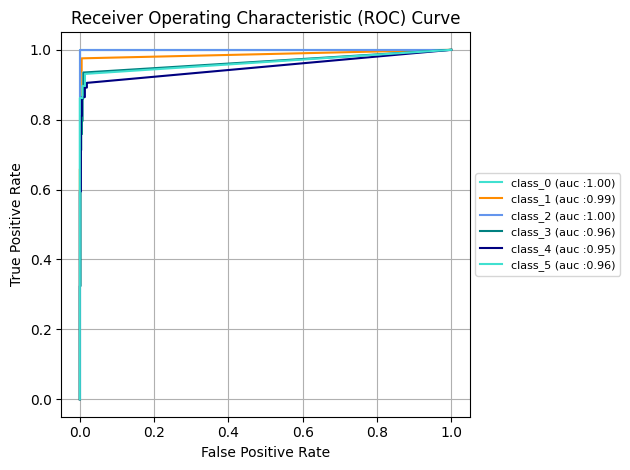

In [ ]:
# Run functions
train(train_dir, valid_dir, test_dir, img_size,
      num_epochs, callbacks, learning_rate,
      export_path)
evaluate(train_dir, valid_dir, test_dir, 
         img_size,export_path)

In [ ]:
# Zip result model
!zip -r result_model.zip logs/ lightning_logs/ plot/ report_model.md resnet152.png \
    resnet152_pr_curve.png resnet152_roc_curve.png

  adding: logs/ (stored 0%)
  adding: logs/default/ (stored 0%)
  adding: logs/default/version_6/ (stored 0%)
  adding: logs/default/version_6/hparams.yaml (stored 0%)
  adding: logs/default/version_6/events.out.tfevents.1631724616.a456b97d9e50.825.0 (deflated 73%)
  adding: logs/default/version_1/ (stored 0%)
  adding: logs/default/version_1/events.out.tfevents.1631723932.a456b97d9e50.150.1 (deflated 33%)
  adding: logs/default/version_0/ (stored 0%)
  adding: logs/default/version_0/events.out.tfevents.1631723904.a456b97d9e50.150.0 (deflated 33%)
  adding: logs/default/version_2/ (stored 0%)
  adding: logs/default/version_2/events.out.tfevents.1631724160.a456b97d9e50.575.0 (deflated 33%)
  adding: logs/default/version_3/ (stored 0%)
  adding: logs/default/version_3/events.out.tfevents.1631724186.a456b97d9e50.575.1 (deflated 33%)
  adding: logs/default/version_4/ (stored 0%)
  adding: logs/default/version_4/events.out.tfevents.1631724250.a456b97d9e50.575.2 (deflated 33%)
  adding: logs